In [81]:
import csv

def parse_txt(filename, oriented=True):
    """
    Parse data from txt file into dict python type.
    JSON serializable.
    """
    data = {}
    with open(filename) as file:
        
        line = file.readline()
        while line:
            
            # skip comments
            if line[0] == '#':
                line = file.readline()
                continue
            
            parent, child = line.split()
            
            parent = int(parent)
            child = int(child)
            
            # rows in data file can be duplicated
            if parent in data:
                if child not in data[parent]['linked']:
                    data[parent]['linked'].append(child)
                    data[parent]['degree'] += 1
            else:
                data[parent] = { 
                    'linked': [child],
                    'degree': 1,
                }
                
            if oriented:
                if child not in data:
                    data[child] = { 
                    'linked': [],
                    'degree': 0,
                }
                
            else:
                if child in data:
                    if parent not in data[child]['linked']:
                        data[child]['linked'].append(parent)
                        data[child]['degree'] += 1

                else:    
                    data[child] = {
                        'linked': [parent],
                        'degree': 1,
                    }

            line = file.readline()

    return data

def parse_csv(filename, oriented=True):
    data = {}
    
    with open(filename) as file:
        reader = csv.reader(file)
        next(reader)
        
        for row in reader:
            
            parent = int(row[0])
            child = int(row[1])
            
            if parent in data:
                if child not in data[parent]['linked']:
                    data[parent]['linked'].append(child)
                    data[parent]['degree'] += 1
            else:
                data[parent] = { 
                    'linked': [child],
                    'distances': {},
                    'degree': 1,
                    'centrality': 0,
                    'marked': False,
                    'active': True
                }
                
            if oriented:
                if child not in data:
                    data[child] = { 
                    'linked': [],
                    'distances': {},
                    'degree': 1,
                    'centrality': 0,
                    'marked': False,
                    'active': True
                }
                
            else:
                if child in data:
                    if parent not in data[child]['linked']:
                        data[child]['linked'].append(parent)
                        data[child]['degree'] += 1

                else:    
                    data[child] = {
                        'linked': [parent],
                        'distances': {},
                        'degree': 1,
                        'centrality': 0,
                        'marked': False,
                        'active': True
                    }
                    
    return data

def parse(filename, oriented=True):
    if filename.split('.')[-1] == 'txt':
        return parse_txt(filename, oriented)
    elif filename.split('.')[-1] == 'csv':
        return parse_csv(filename, oriented)

In [82]:
FILENAME = 'web-Google.txt'
#FILENAME = 'CA-AstroPh.txt'
#FILENAME = 'test.txt'
ORIENTED = True


In [83]:
data = parse(FILENAME, ORIENTED)
#print(data)

In [86]:
def count_vertices(graph):
    return len(graph)

def count_edges(graph,oriented = False):
    edges = 0
    for item in graph.values():
        edges += item['degree']
    if oriented:
        return edges
    return edges / 2

vertices = count_vertices(data)
edges = count_edges(data,ORIENTED)
complete_graph_edges = vertices * (vertices - 1) / 2

print(f'Number of vertices in {FILENAME}: {vertices}')
print(f'Number of edges in {FILENAME}: {edges}')
print(f'Number of edges in complete graph: {complete_graph_edges}')
print(f'Density: {edges / complete_graph_edges}')

Number of vertices in web-Google.txt: 875713
Number of edges in web-Google.txt: 5105039
Number of edges in complete graph: 383436191328.0
Density: 1.3313920583028727e-05


In [ ]:
#def dfs(graph, start, visited=None):
#    if visited is None:
#        visited = set()
#    visited.add(start)
#    for next in set(graph[start]["linked"]) - visited:
#        dfs(graph, next, visited)
#    return visited

#def get_weak_connectivity_components(graph):
#    weak_connectivity_components = []
#    max_component = []
#    nodes = []
#    for item in graph.keys():
#        if item not in nodes:
#            component = dfs(graph,item)
#            for key in component:
#                nodes.append(key)
#            if len(component) > len(max_component):
#                max_component = component
#            weak_connectivity_components.append(component)
                
#    return (weak_connectivity_components, max_component)

def get_weak_connectivity_components(graph):
    weak_connectivity_components = []
    nodes = []
    for item in graph.keys():
        if item not in nodes:
            visited = set()
            stack = []
            stack.append(item)
            while stack:
                start = stack.pop()
                for next in set(graph[start]['linked']) - visited:
                    if next not in visited and next not in nodes:
                        stack.append(next)
                        visited.add(next)
            for key in visited:
                nodes.append(key)
            weak_connectivity_components.append(list(visited))
                
    return weak_connectivity_components

def make_unoriented(graph):
    result = dict.fromkeys(graph.keys(),{})
    for key in graph.keys():
        result[key] = graph[key]
    for key in result.keys():
        for vertex in graph[key]['linked']:
            if key not in result[vertex]['linked'] and key != vertex:
                result[vertex]['linked'].append(key)
                result[vertex]['degree'] += 1
    return result
    
    
weak_connectivity_components = get_weak_connectivity_components(make_unoriented(data))
max_weak_connectivity_component = []
for component in weak_connectivity_components:
    if len(component) > len(max_weak_connectivity_component):
        max_weak_connectivity_component = component
        
max_weak_connectivity_component_size = len(max_weak_connectivity_component)
#print(weak_connectivity_components)
print(max_weak_connectivity_component_size)
print(f'Number of weak connectivity components in {FILENAME}: {len(weak_connectivity_components)}')
print(f'Proportion of vertices in max weak connectivity component: {max_weak_connectivity_component_size/vertices}')

In [85]:
def strongly_connected_components_iterative(graph):
    identified = set()
    stack = []
    index = {}
    boundaries = []

    for v in graph.keys():
        if v not in index:
            to_do = [('VISIT', v)]
            while to_do:
                operation_type, v = to_do.pop()
                if operation_type == 'VISIT':
                    index[v] = len(stack)
                    stack.append(v)
                    boundaries.append(index[v])
                    to_do.append(('POSTVISIT', v))
                    to_do.extend(
                        reversed([('VISITEDGE', w) for w in graph[v]['linked']]))
                elif operation_type == 'VISITEDGE':
                    if v not in index:
                        to_do.append(('VISIT', v))
                    elif v not in identified:
                        while index[v] < boundaries[-1]:
                            boundaries.pop()
                else:
                    if boundaries[-1] == index[v]:
                        boundaries.pop()
                        scc = set(stack[index[v]:])
                        del stack[index[v]:]
                        identified.update(scc)
                        yield scc


def get_max_strong_connectivity_component_size(components):
    maximum = 0
    for item in components:
        if len(item) > maximum:
            maximum = len(item)
    return maximum

if ORIENTED:
    sccs = []
    for scc in strongly_connected_components_iterative(data):
        sccs.append(scc)
    #print(sccs)
    max_strong_connectivity_component_size = get_max_strong_connectivity_component_size(sccs)
    print(f'Number of strong connectivity components in {FILENAME}: {len(sccs)}')
    print(f'Proportion of vertices in max strong connectivity component: {max_strong_connectivity_component_size/vertices}')
    print(f'Max strong connectivity component size: {max_strong_connectivity_component_size}')

Number of strong connectivity components in web-Google.txt: 371764
Proportion of vertices in max strong connectivity component: 24156.555555555555
Max strong connectivity component size: 434818


In [80]:
def fill_component(component,data):
    result = {}
    for node in component:
        result[node] = data[node]
    for key,values in result.items():
        for value in values['linked']:
            if value not in component:
                result[key]['linked'] = [x for x in result[key] if x != value]
    return result
        
filled_component = fill_component(max_weak_connectivity_component,make_unoriented(data))

In [ ]:
from collections import deque
import random 

def shortest_path(graph, source, vertices):
    unvisited_vertices = set(vertices)
    unvisited_vertices.discard(source)
    lengths = {source: 0}
    queue = deque([(source,0)])
    while unvisited_vertices:
        v, length = queue.popleft()
        for n in graph[v]['linked']:
            if n not in lengths:
                queue.append((n, length+1))
                lengths[n] = length+1
                unvisited_vertices.discard(n)
    return {v: lengths[v] for v in vertices}
            
def distances(graph, number_of_verticies):
    keys = [x for x in graph.keys()]
    random.shuffle(keys)
    random_keys = keys[0:number_of_verticies]
    distances = {}
    for i in random_keys:
        distances[i] = shortest_path(graph,i,random_keys)
    return distances

distances = distances(filled_component,500)
print(distances)

{14908016: {14908016: 0, 14670343: 2, 9749512: 1, 1416039: 2, 1773716: 2, 5195143: 2, 2471289: 2, 6184016: 2, 2383363: 2, 404232: 2, 11770079: 2, 8602899: 2, 567350: 2, 7969486: 2}, 14670343: {14908016: 2, 14670343: 0, 9749512: 1, 1416039: 2, 1773716: 2, 5195143: 2, 2471289: 2, 6184016: 2, 2383363: 2, 404232: 2, 11770079: 2, 8602899: 2, 567350: 2, 7969486: 2}, 9749512: {14908016: 1, 14670343: 1, 9749512: 0, 1416039: 1, 1773716: 1, 5195143: 1, 2471289: 1, 6184016: 1, 2383363: 1, 404232: 1, 11770079: 1, 8602899: 1, 567350: 1, 7969486: 1}, 1416039: {14908016: 2, 14670343: 2, 9749512: 1, 1416039: 0, 1773716: 2, 5195143: 2, 2471289: 2, 6184016: 2, 2383363: 2, 404232: 2, 11770079: 2, 8602899: 2, 567350: 2, 7969486: 2}, 1773716: {14908016: 2, 14670343: 2, 9749512: 1, 1416039: 2, 1773716: 0, 5195143: 2, 2471289: 2, 6184016: 2, 2383363: 2, 404232: 2, 11770079: 2, 8602899: 2, 567350: 2, 7969486: 2}, 5195143: {14908016: 2, 14670343: 2, 9749512: 1, 1416039: 2, 1773716: 2, 5195143: 0, 2471289: 2, 6

In [ ]:
import math

def get_diameter(distances):
    diameter = 0
    for key, values in distances.items():
        for node, distance in values.items():
            if distance > diameter:
                diameter = distance
    return diameter

def get_radius(distances):
    radius = 1000000000000000
    for key, values in distances.items():
        e = 0
        for node, distance in values.items():
            if distance > e:
                e = distance
        if radius > e:
            radius = e
    return radius

def get_r_percentile(distances,r):
    d = []
    for key, values in distances.items():
        for node, distance in values.items():
            d.append(distance)
    d.sort()
    return d[math.ceil(len(d)*r/100)]

print(f"diameter: {get_diameter(distances)}")
print(f"raidus: {get_radius(distances)}")
print(f"90 percentile: {get_r_percentile(distances,90)}")

diameter: 2
raidus: 1
90 percentile: 2


In [ ]:
#!pip install seaborn
!pip install matplotlib

You should consider upgrading via the 'C:\Users\mytht\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [ ]:
import matplotlib.pyplot as plt
import math 

def get_degrees(graph):
    min_degree = 100000000000000
    max_degree = 0
    avg_degree = 0
    for vertex in graph.values():
        if vertex['degree'] > max_degree:
            max_degree = vertex['degree']
        if vertex['degree'] < min_degree:
            min_degree = vertex['degree']
        avg_degree += vertex['degree']
    return (min_degree,max_degree,avg_degree / len(graph.keys()))

[min_degree,max_degree,avg_degree] = get_degrees(data)
print(f'Minimum degree: {min_degree}')
print(f'Maximum degree: {max_degree}')
print(f'Average degree: {avg_degree}')

def get_distribution(graph,degrees):
    
    degree_sum = 0
    for value in graph.values():
        degrees[value['degree']] += 1
        degree_sum += value['degree']
    for key in degrees.keys():
        degrees[key] /= degree_sum
    return degrees
    
def get_log_log(distribution):
    res = {}
    for key,value in distribution.items():
        res[f'{math.log10(key+1)}'] = math.log10(value+1)
    return res
    
distribution = get_distribution(data,dict.fromkeys(list(range(min_degree,max_degree+1)),0))
log_distribution = get_log_log(distribution)

Minimum degree: 1
Maximum degree: 13
Average degree: 1.0498949579831933


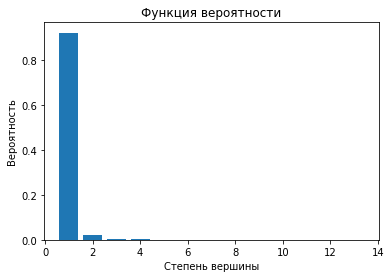

In [ ]:
#sns.histplot(data=list(distribution.values()),bins=30)
plt.bar(distribution.keys(), distribution.values())
  
# naming the x axis
plt.xlabel('Степень вершины')
# naming the y axis
plt.ylabel('Вероятность')
# giving a title to my graph
plt.title('Функция вероятности')
  
# function to show the plot
plt.show()

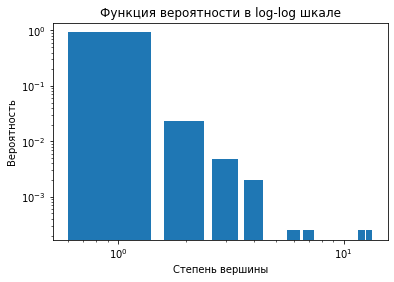

In [ ]:
#sns.histplot(distribution,log_scale=True)
plt.bar(distribution.keys(), distribution.values())
  
# naming the x axis
plt.xlabel('Степень вершины')
# naming the y axis
plt.ylabel('Вероятность')
plt.xscale('log')
plt.yscale('log')  
# giving a title to my graph
plt.title('Функция вероятности в log-log шкале')
  
# function to show the plot
plt.show()